## Уравнения

Уравнение неразрывности для смачиваемой жидкости:
$$
\begin{gathered}

\phi \frac{\partial S}{\partial t} + W \frac{\partial b(S)}{\partial x} = 0 ,

\end{gathered}
$$

где $W$ - суммарная скорость фильтрации,
$$ W = \frac{Q}{F} $$
$b(S)$ - функция Баклея-Леверетта:

$$
\begin{gathered}

b(S) = \frac{f_1(S)}{f_1(S) + \frac{\mu_1}{\mu_2} {f_2(S)}},

\end{gathered}
$$

## Численное решение

### Дискретизация

Уравнение неразрывности:
$$
\phi \frac{S_{i}^{n+1} - S_{i}^{n}}{\tau} + W \frac{b(S_{i}^n) - b(S_{i-1}^n)}{h} = 0
$$
Число Куранта:
$$


C = \frac{W \tau}{\phi h} ≤ 0.5 \hspace{1cm} \tau ≤ \frac{\phi h}{2 W}
$$

### Библиотеки

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numba

%load_ext autoreload
%autoreload 2

### Функции

In [3]:
EPS = 0.15 # параметр схемной вязкости [0, 1), чем больше - тем сильнее размываются разрывы
# чем меньше - тем сильнее проявляются нефизичные осцилляции

WATER_CURVE_SHAPE_PARAMETER = 2.5
OIL_CURVE_SHAPE_PARAMETER = 2
S_WIR = 0.
S_ORW = 0.

# Corey-model
@numba.njit
def normalized_s(S:float) -> float:
    return (S - S_WIR) / (1 - S_WIR - S_ORW)

@numba.njit
def k1(S:float) -> float:
    """Relative permeability to water

    Args:
        S (float): Water saturation
        n (float): n power

    Returns:
        float: Relative permeability to water
    """
    if S <= S_WIR:
        return 0.0
    elif S >= (1 - S_ORW):
        return 1.0
    else:
        return np.power(normalized_s(S), WATER_CURVE_SHAPE_PARAMETER)

@numba.njit
def k2(S:float) -> float:
    """Relative permeability to oil

    Args:
        S (float): Water saturation
        n (float): n power

    Returns:
        float: Relative permeability to oil
    """
    if S <= S_WIR:
        return 1.0
    elif S >= (1 - S_ORW):
        return 0.0
    else:
        return np.power((1 - normalized_s(S)), OIL_CURVE_SHAPE_PARAMETER)

@numba.njit
def b(S:float, viscosity_1:float, viscosity_2:float) -> float:
    """Buckley-Leverett function calculation

    Args:
        S (float): Water saturation
        viscosity_1 (float): Water viscosity
        viscosity_2 (float): Oil viscosity

    Returns:
        float: Buckley-Leverett function of S
    """
    return k1(S) / (k1(S) + viscosity_1 / viscosity_2 * k2(S))

@numba.njit(parallel=True)
def calculate_saturation_linear_field(S, Nt, Nl, W, dt, dl, porosity, viscosity1, viscosity2):
    for n in np.arange(1, Nt):
        for i in np.arange(1, Nl):
            S[n, i] = S[n-1, i] - W * dt / (porosity * dl) * (b(S[n-1, i], viscosity1, viscosity2) - b(S[n-1, i-1], viscosity1, viscosity2))

### Входные параметры

In [108]:
# Геометрия
width = 1
height = 1
length = 100

# Хар-ки породы
permeability = 1 * 10**(-12)
porosity = 0.2

# Хар-ки флюидов
viscosity1 = 1 * 10**(-3)
viscosity2 = 4 * 10**(-3)

# Расход
flow = 10 * 10**(-3)

# Насыщенность
saturation_left = 1 - S_ORW
saturation_initial = S_WIR

# Кол-во узлов сетки
num_of_grid_points = 1000

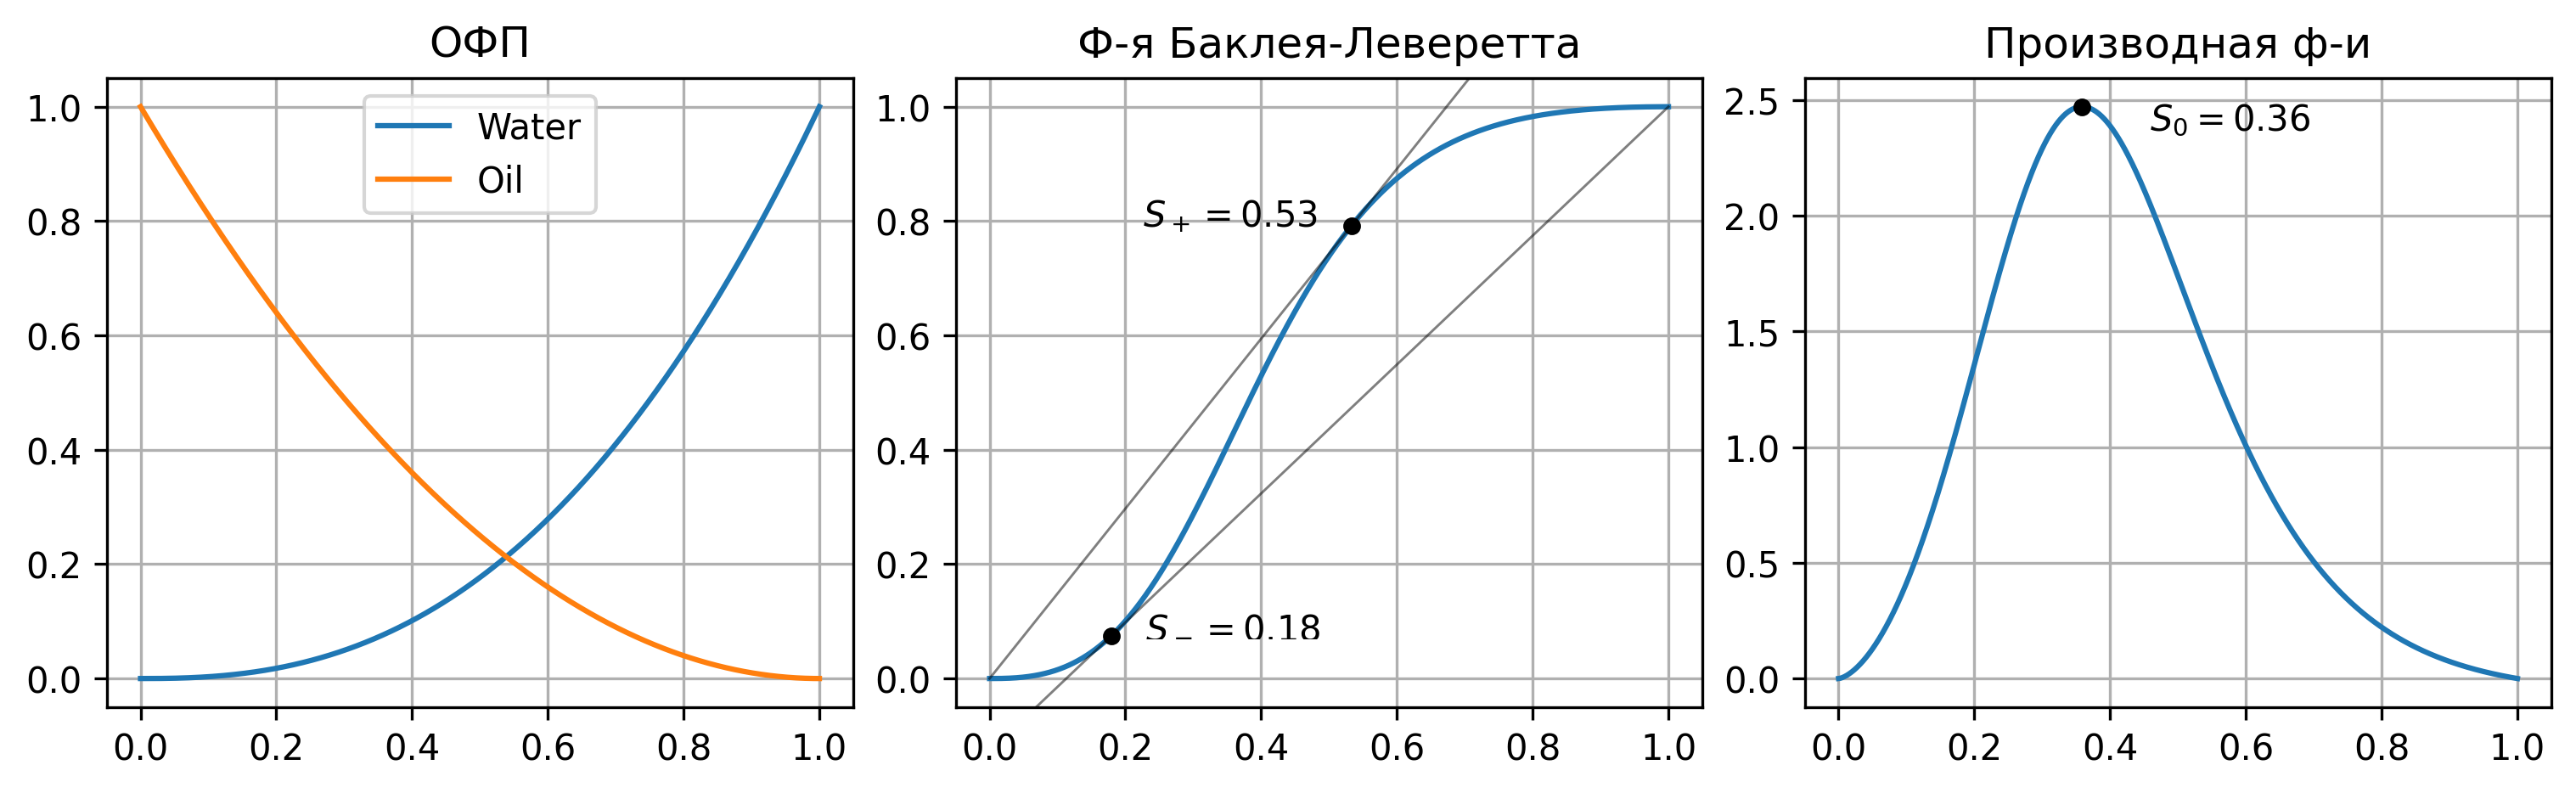

In [122]:
# Графики Баклея-Леверетта
ds = 0.00001
s = np.arange(S_WIR, (1-S_ORW) + ds, ds)
f_s = np.zeros_like(s)
for i in range(len(s)):
    f_s[i] = b(s[i], viscosity1, viscosity2)
df_s = np.gradient(f_s) * len(s)
s_center = s[np.where(np.isclose(df_s, np.max(df_s)))][0]

fig, axs = plt.subplots(1, 3, figsize=(10, 3), layout='constrained', dpi=300)
# fig.suptitle("")

axs[0].set_title("ОФП")
axs[0].grid()
axs[0].plot(s, [k1(i) for i in s], s, [k2(i) for i in s])
axs[0].legend(["Water", "Oil"])
axs[0].set_xlim([0-0.05, 1+0.05])

axs[1].plot(s, f_s)
axs[1].grid()
axs[1].set_ylim([-0.05, 1.05])
axs[1].set_title("Ф-я Баклея-Леверетта")
# построение касательных к функции Б-Л
k_right = 0
k_left = 0
s_right = 0
s_left = 0
for k in np.arange(max(df_s), min(df_s), -ds):
    if np.min(k * (s - S_WIR) - f_s) < 0:
        k_right = k
        s_right = np.max(s * ((k * (s - S_WIR) - f_s) < 0))
        break
axs[1].plot(s, k_right * (s - S_WIR), color="black", alpha=0.5, linewidth=0.7)
axs[1].plot(s_right, b(s_right, viscosity1, viscosity2), marker="o", color="black", alpha=1, markersize=4)
axs[1].text(s_right-0.05, b(s_right, viscosity1, viscosity2), rf'$S_+={round(s_right, 2)}$', fontsize=10, horizontalalignment='right')
for k in np.arange(max(df_s), min(df_s), -ds):
    if np.max(k * (s+S_ORW-1) + 1 - f_s) > 0:
        k_left = k
        s_left = np.max(s * ((k * (s+S_ORW-1) + 1 - f_s) > 0))
        break
axs[1].plot(s, k_left * (s+S_ORW-1) + 1, color="black", alpha=0.5, linewidth=0.7)
axs[1].plot(s_left, b(s_left, viscosity1, viscosity2), marker="o", color="black", alpha=1, markersize=4)
axs[1].text(s_left+0.05, b(s_left, viscosity1, viscosity2), rf'$S_-={round(s_left, 2)}$', fontsize=10)
axs[1].set_xlim([0-0.05, 1+0.05])

axs[2].plot(s, df_s)
axs[2].grid()
axs[2].set_title("Производная ф-и")
axs[2].plot(s_center, np.max(df_s), marker="o", color="black", markersize=4)
axs[2].text(s_center + 0.1, np.max(df_s) - 0.1, rf'$S_0={round(s_center, 2)}$', fontsize=10)
axs[2].set_xlim([0-0.05, 1+0.05])

plt.show()

# del ds, s, f_s, df_s, k_right, k_left
# f_s

### Инициализация

In [109]:
velocity = flow / (height * width)

x, h = np.linspace(0, length, num_of_grid_points, endpoint=True, retstep=True)

# Время расчета
total_time = length * s_right / b(s_right, viscosity1, viscosity2) / velocity * porosity / 3
tau = porosity * h / (2 * velocity) * (1 - EPS)
t = np.arange(0, total_time + tau, tau)
num_of_time_points = t.shape[0]

# W = np.zeros([num_of_time_points, num_of_grid_points])
S = np.zeros([num_of_time_points, num_of_grid_points])
S[0, :] = saturation_initial
S[:, 0] = saturation_left 
total_time

1346.22737994427

In [110]:
calculate_saturation_linear_field(S, num_of_time_points, num_of_grid_points, velocity, tau, h, porosity, viscosity1, viscosity2)

Точное решение

In [112]:
u = velocity / porosity * df_s

D = 0
for i in range(len(s)-1, -1, -1):
    if s[i] <= s_right:
        if D == 0:
            D = u[i]
        u[i] = D

xx = np.zeros([len(t), len(u)])
for n in range(len(t)):
    for j in range(len(u)):
        xx[n, j] = u[j] * t[n]

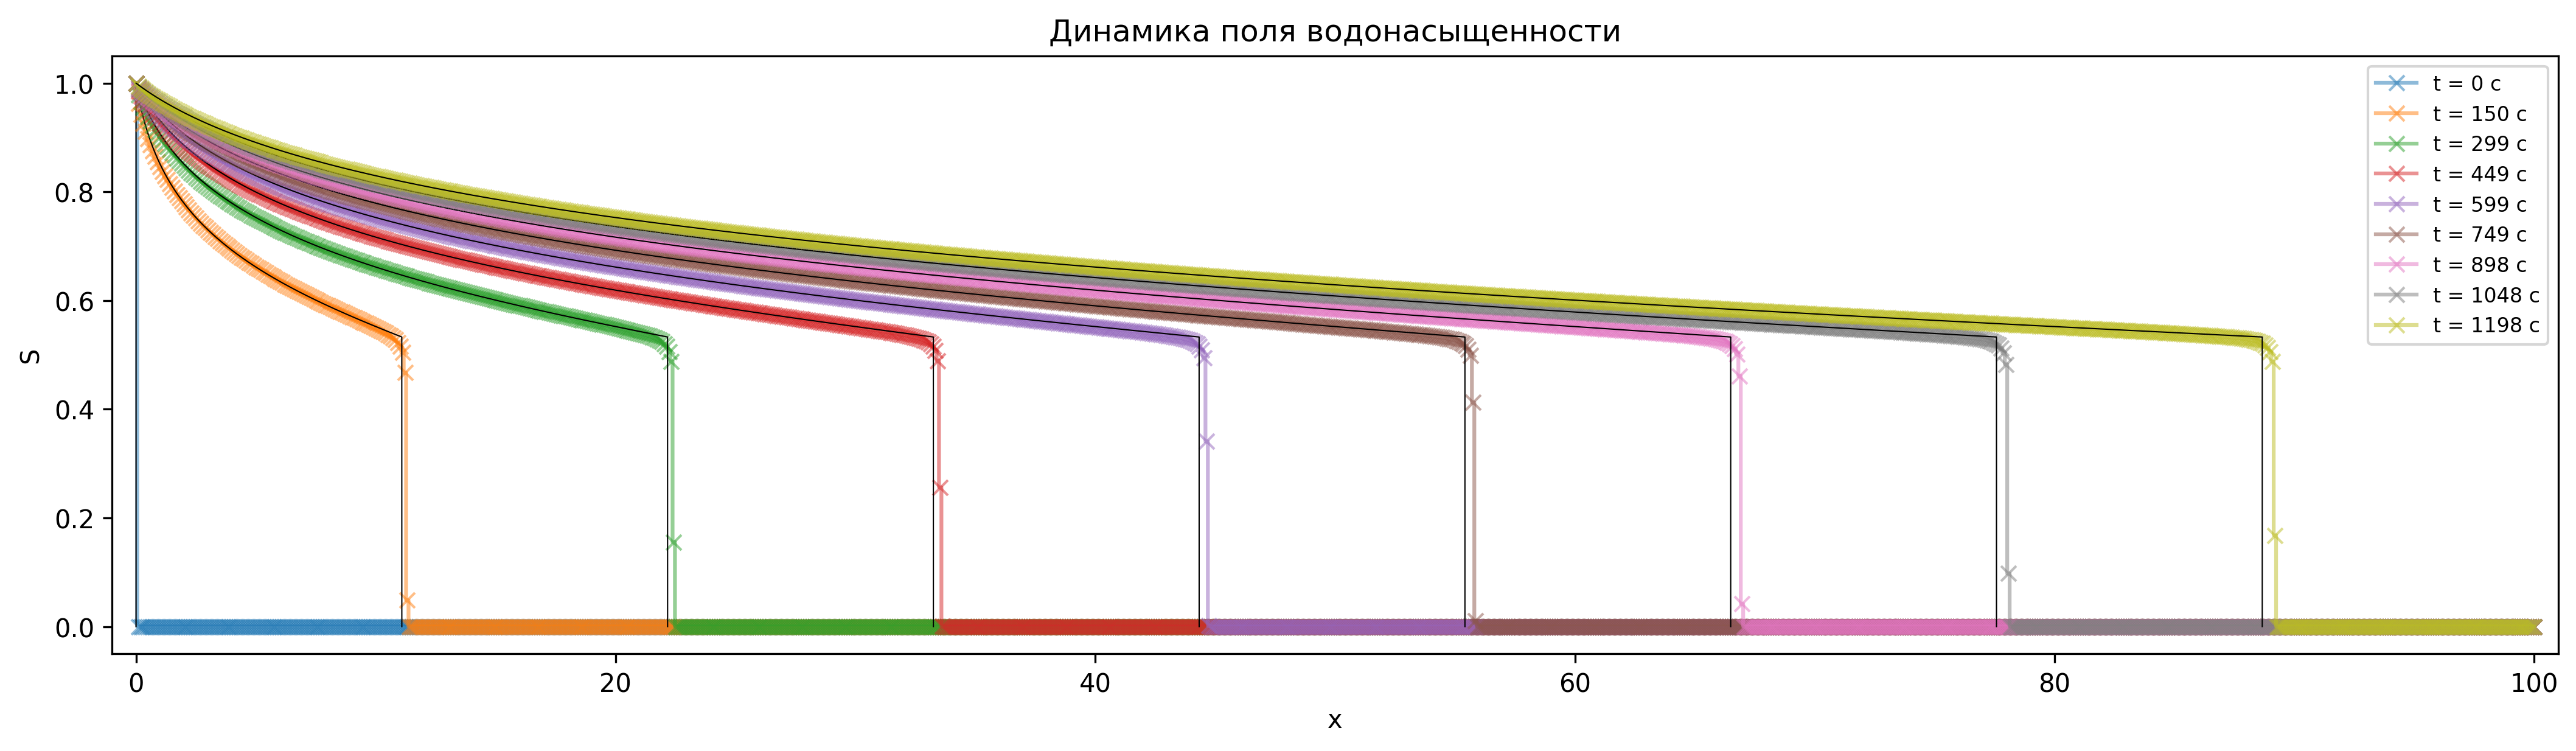

In [144]:
# n - кол-во кривых на графике
n = 10

fig, ax = plt.subplots(figsize=(14, 4), layout='constrained', dpi=300)

for i in range(num_of_time_points):
    if i % (num_of_time_points // (n-1)) == 0:
        ax.step(x, S[i], label=f"t = {round(t[i])} с", where='mid', marker="x", alpha=0.5)
        ax.plot(xx[i], s, linewidth=0.5, c="black")

plt.title("Динамика поля водонасыщенности")
# ax.plot(x, np.ones_like(x, dtype=float) * s_right, color="black", alpha=0.2)
# ax.plot(x, np.ones_like(x, dtype=float) * s_left, color="black", alpha=0.2)
# ax.plot(x, np.ones_like(x, dtype=float) * s_center, color="black", alpha=0.2)
# ax.grid()
# ax.set_xticks(x, minor=True)
ax.set_ylabel("S")
ax.set_xlabel("x")
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([-0.01 * length, length * 1.01])
# ax.set_xlim([9.7, 10.2])
plt.legend(fontsize=8)
plt.show()

In [135]:
U = velocity / porosity * df_s

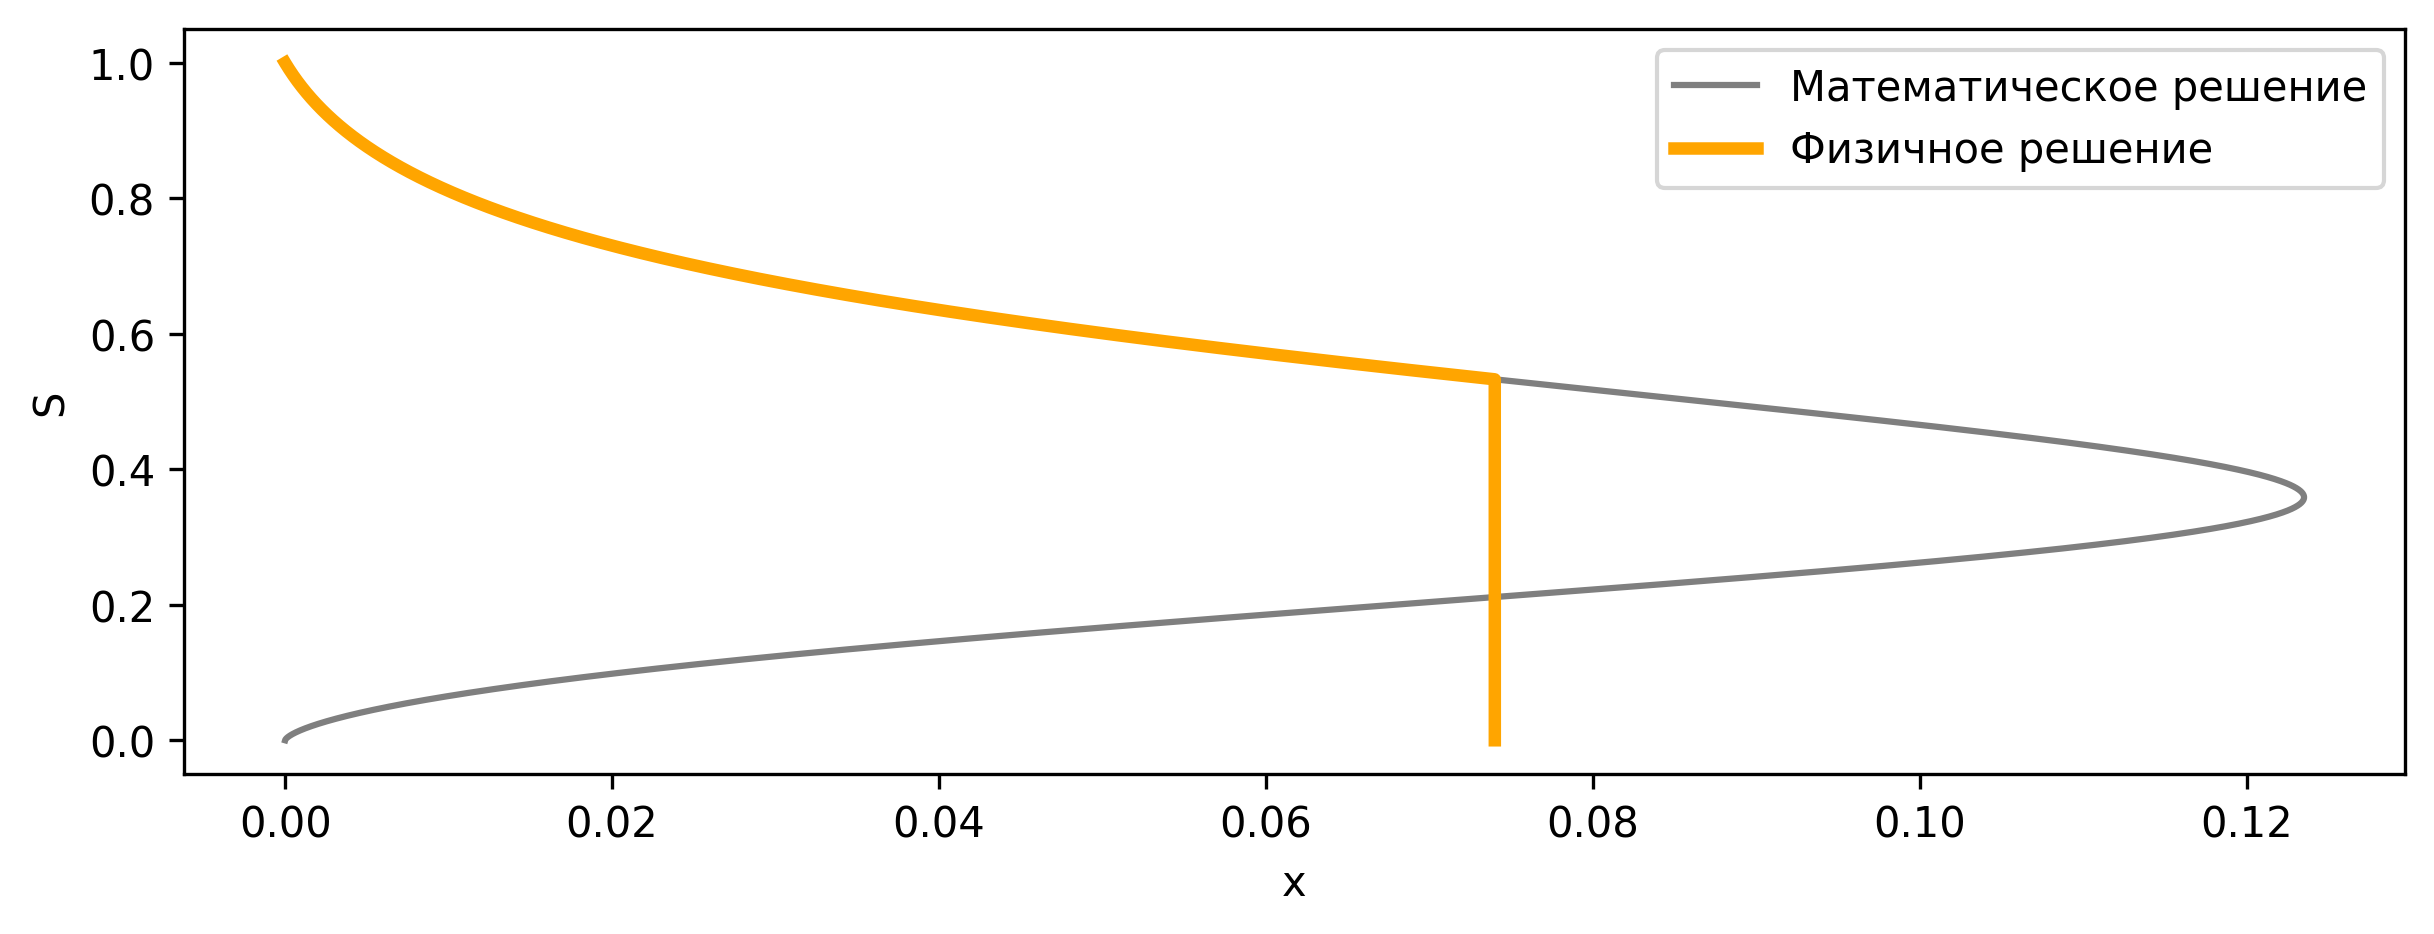

In [151]:
fig, ax = plt.subplots(figsize=(8, 3), layout='constrained', dpi=300)

ax.set_ylabel("S")
ax.set_xlabel("x")
ax.plot(U, s, alpha=0.5, c="black", label="Математическое решение")
ax.plot(u, s, color="orange", linewidth=3, label="Физичное решение")
ax.legend()
plt.show()

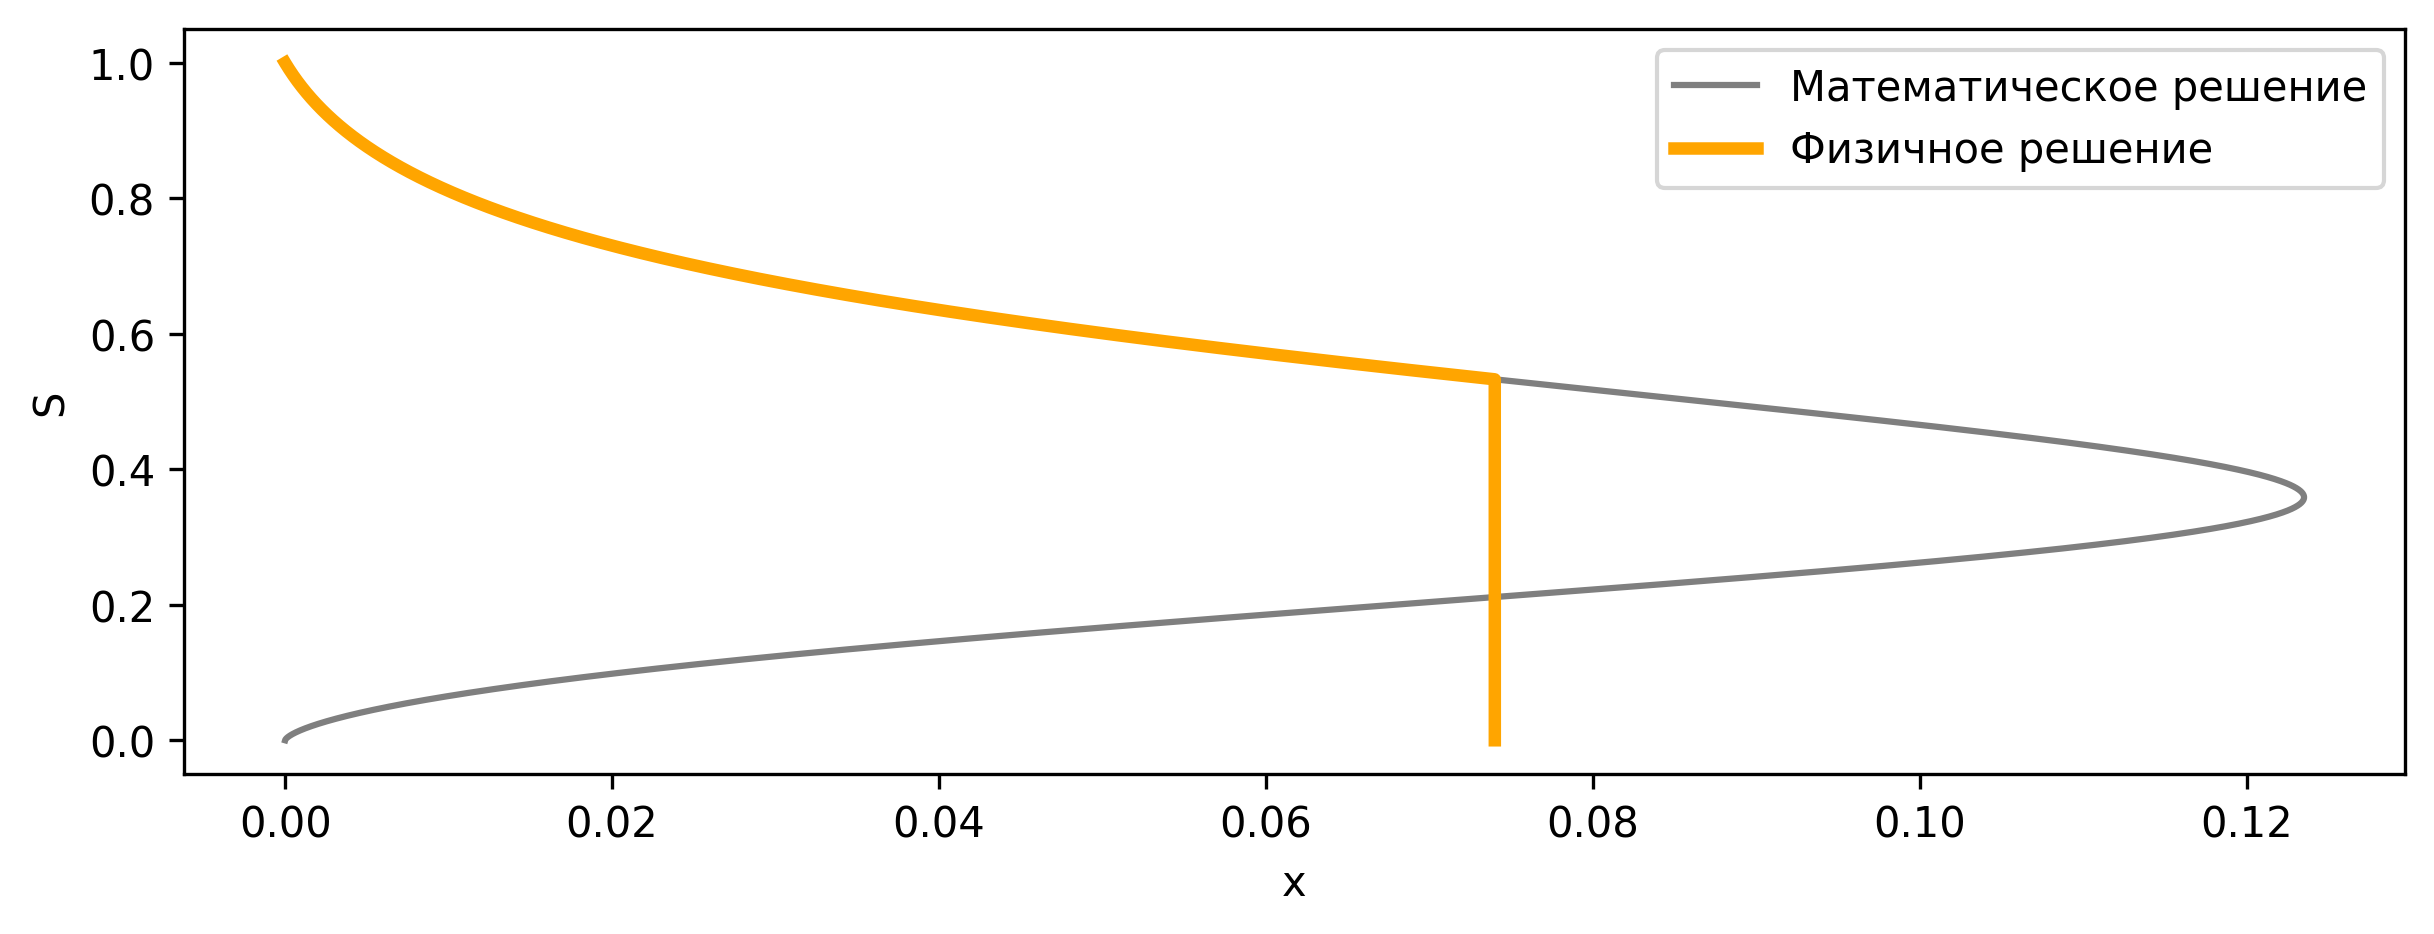

In [152]:
fig, ax = plt.subplots(figsize=(8, 3), layout='constrained', dpi=300)

ax.set_ylabel("S")
ax.set_xlabel("x")
ax.plot(U, s, alpha=0.5, c="black", label="Математическое решение")
ax.plot(u, s, color="orange", linewidth=3, label="Физичное решение")
ax.legend()
plt.show()

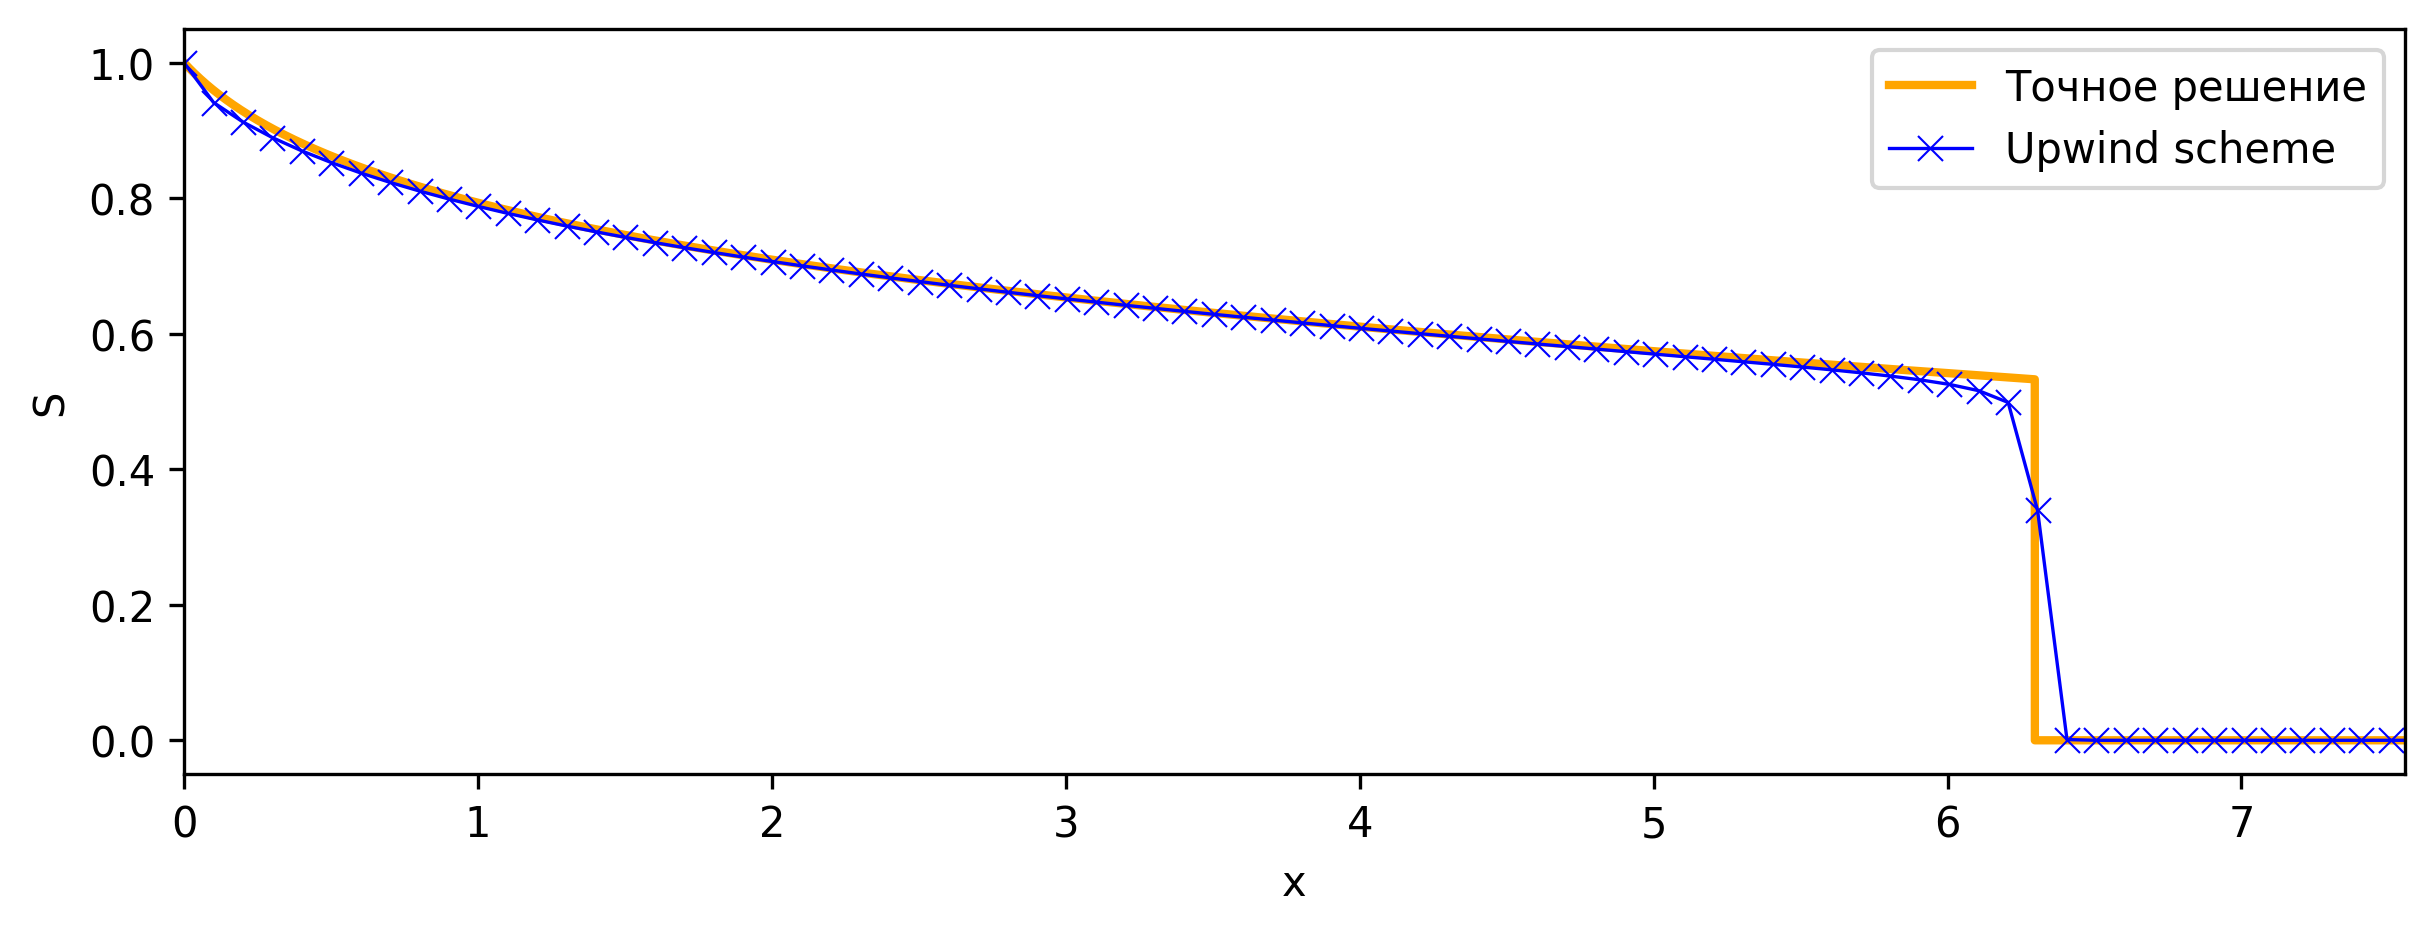

In [182]:
fig, ax = plt.subplots(figsize=(8, 3), layout='constrained', dpi=300)

ax.set_ylabel("S")
ax.set_xlabel("x")
ax.plot(np.insert(u * t[100], 0, length), np.insert(s, 0, 0), color="orange", linewidth=2, label="Точное решение")
ax.plot(x, S[98], alpha=1, c="blue", label="Upwind scheme", marker="x", linewidth=0.8, markeredgewidth=0.5)
ax.legend()
ax.set_xlim([0, 1.2*np.max(u * t[100])])
plt.show()